# How to use the rtfits-module

In [1]:
import numpy as np
import pandas as pd

from rt1.rtfits import Fits
import rt1.volume as rt_V
import rt1.surface as rt_SRF

# Generation of a Dataset



In [2]:
# define Volume- and Surface properties used for the generation of the dataset
def set_V_SRF_orig(tau, omega, N):
    V = rt_V.Rayleigh(omega = omega, tau = tau)
    SRF = rt_SRF.LinCombSRF([[0.5, rt_SRF.Isotropic()], 
                             [0.5, rt_SRF.CosineLobe(i=8, ncoefs=10)]], 
                            NormBRDF=N)
    return V, SRF

fit = Fits(sig0=True, dB=False, verbose=0, set_V_SRF = set_V_SRF_orig, int_Q=True,
           defdict=dict(tau=  [False, 'auxiliary'], 
                        omega=[False, 'auxiliary'], 
                        N=    [False, 'auxiliary']))


# define parameters for the simulated dataset
index = pd.date_range('1.1.2018', '1.5.2018')
inc = np.deg2rad(np.arange(1,90,1))
# print fit-results
simulation_param = pd.DataFrame(dict(tau =   [.2, .5, .3,  .56, .32],
                                     omega = [.1, .1, .54, .23, .62],
                                     N =     [.4, .6, .8,  .12, .24]), 
                                index=index)


# evaluate the model for the given set of parameters
data_sim = fit.calc(param=dict(), fixed_param=simulation_param, inc=inc, return_components=False)

# select only parts of the incidence-angle range and add noise
slices = [slice(4, 75 ,2), slice(9, 45), slice(14, 61), slice(31, 76), slice(20, 55)]
dataset = pd.concat([pd.DataFrame({'sig':data_sim[i][sl], 'inc':inc[sl], 'date':index[i]}).set_index('date')
                     for i, sl in enumerate(slices)])

# add some random noise
max_noise = dataset.sig.max()/20.
noise = np.random.uniform(low=0., high=max_noise, size=len(dataset))
dataset['sig'] = dataset['sig'] + noise

# Fit a different model to the data

-----------------------------------------------------------------------------
# SCATTERING FUNCTIONS 
 Volume: Rayleigh                    | Surface: HenyeyGreenstein

# Interaction-contribution?      True

----------------------------- FITTED PARAMETERS -----------------------------
     NAME     |     START    |  VARIABILITY  |    BOUNDS    | INTERPOLATION |
 tau          | 0.2          | D             | 0.0-1.0      | False         |
 omega        | 0.2          | D             | 0.0-1.0      | False         |
 N            | 0.2          | D             | 0.0-1.0      | False         |

--------- FIXED PARAMETERS ----------|---------- AUXILIARY DATASETS ---------
-----------------------------------------------------------------------------
# LSQ PARAMETERS 
 verbose        = 0                    xtol           = 0.001
 ftol           = 1e-05                max_nfev       = 100
-----------------------------------------------------------------------------
Done! (`xtol` termination co

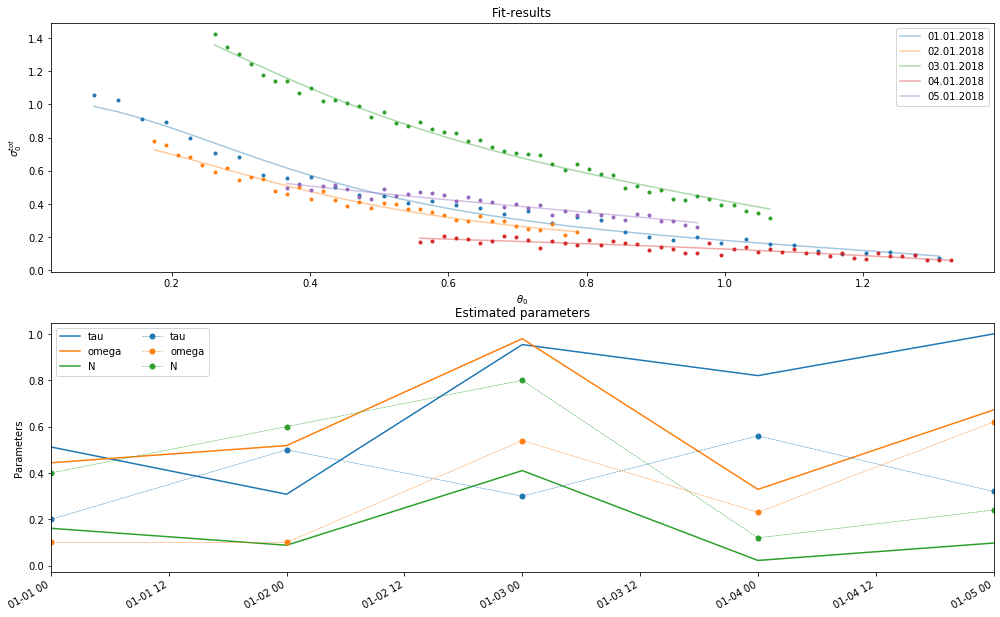

In [3]:
# define Model to be fitted to the dataset
# NOTE this is not the same specification as in the generation of the dataset! (so parameters WILL BE DIFFERENT !)
def set_V_SRF(omega, tau, N):
    V = rt_V.Rayleigh(omega = omega, tau = tau)
    SRF = rt_SRF.HenyeyGreenstein(t=0.35, ncoefs=10, NormBRDF = N)
    return V, SRF

defdict = dict(tau =    [True, .2, 'D', ([0.], [1.])],
               omega =  [True, .2, 'D', ([0.], [1.])],
               N =      [True, .2, 'D', ([0.], [1.])])

fit = Fits(dataset=dataset, verbose=0, 
           sig0=True, dB=False, 
           set_V_SRF = set_V_SRF,
           defdict=defdict, int_Q=True,
           lsq_kwargs=dict(verbose=0, 
                           ftol=1e-5, gtol=1e-5, xtol=1e-3,
                           max_nfev=100))
fit.model_definition
fit.performfit(print_progress=True)

# plot the obtained results
fig = fit.plot.results(legend=True, legend_fmt='%d.%m.%Y')
# overplot true-values
_ = simulation_param.plot(ax=fig.axes[1], ls='--', marker='.', ms=10, lw=0.5)
_ = fig.axes[1].legend(ncol=2)

## plot the residuals
#_ = fit.plot.fit_errors()

# Try to re-fit the same model that has been used to generate the data

-----------------------------------------------------------------------------
# SCATTERING FUNCTIONS 
 Volume: Rayleigh                    | Surface: LinCombSRF

# Interaction-contribution?      True

----------------------------- FITTED PARAMETERS -----------------------------
     NAME     |     START    |  VARIABILITY  |    BOUNDS    | INTERPOLATION |
 tau          | 0.2          | D             | 0.0-1.0      | False         |
 omega        | 0.2          | D             | 0.0-1.0      | False         |
 N            | 0.2          | D             | 0.0-1.0      | False         |

--------- FIXED PARAMETERS ----------|---------- AUXILIARY DATASETS ---------
-----------------------------------------------------------------------------
# LSQ PARAMETERS 
 verbose        = 0                    xtol           = 0.0001
 ftol           = 1e-05                max_nfev       = 100
 gtol           = 1e-05                x_scale        = jac
---------------------------------------------------

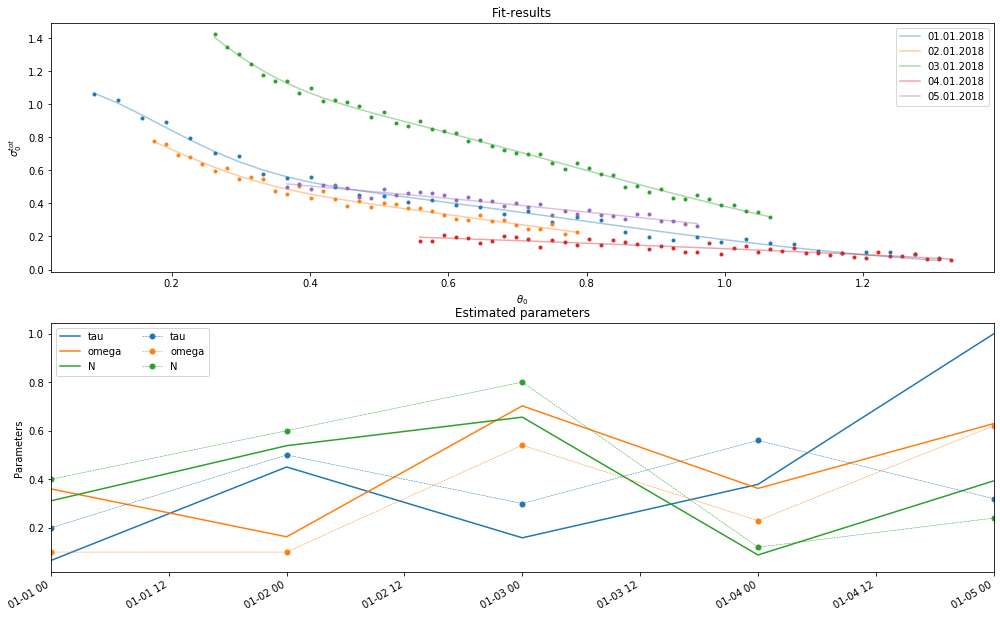

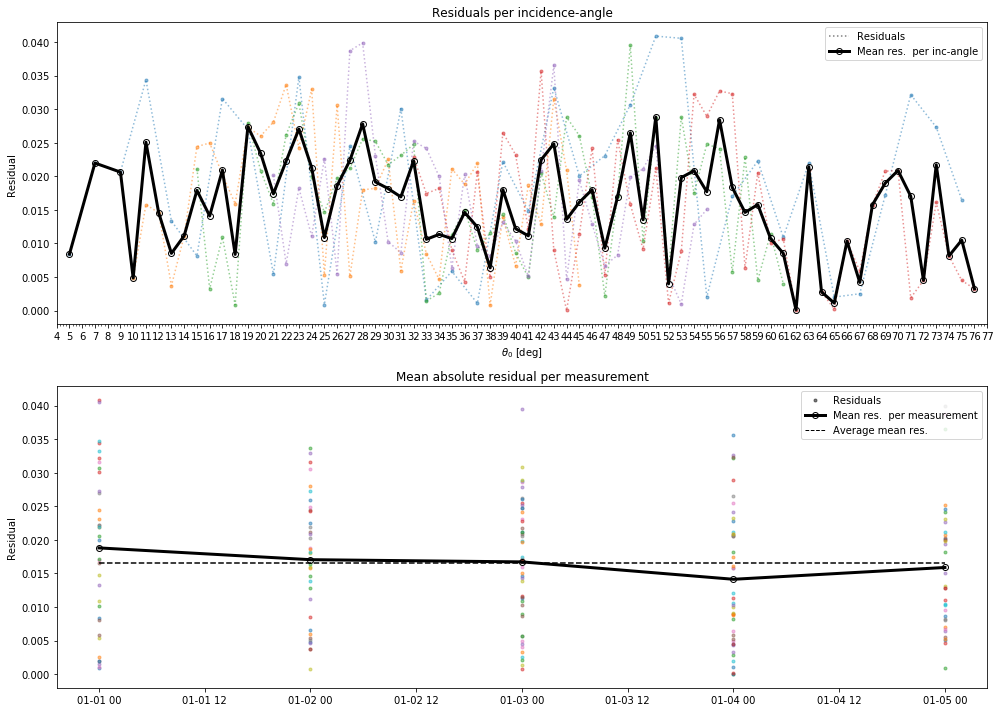

In [7]:
fit = Fits(dataset=dataset, verbose=0, 
           sig0=True, dB=False, 
           set_V_SRF = set_V_SRF_orig,
           defdict=defdict, int_Q=True,
           lsq_kwargs=dict(verbose=0, 
                           ftol=1e-5, gtol=1e-5, xtol=1e-4,
                           max_nfev=100,
                           x_scale='jac'))
fit.model_definition
fit.performfit(print_progress=True)

fig = fit.plot.results(legend=True, legend_fmt='%d.%m.%Y')
# overplot true-values
_ = simulation_param.plot(ax=fig.axes[1], ls='--', marker='.', ms=10, lw=0.5)
_ = fig.axes[1].legend(ncol=2)

## print residuals
_ = fit.plot.fit_errors()